### Explanation
1. This script takes manually reviewed trials checks for how many trials per participant are there.
2. Depending on that we do participant rejection.
3. Then we have a custom function to decide how many datapoint we want to see per trial with distionction of before and after onset.
4. If trial is less than that we add the last value to make it equal to that, same approach as (Dotan et al.)
5. Then depending on that we do averaged mouse trajectory plotting with both X and Y coordinates.
6. After that we once more extract the dataset one more time to get the data in form for our specific way of regression models.


In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as  np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

df = pd.read_json(r"C:\Users\veoni\Documents\GitHub\MTE_DLAB\Analysis\df_manrev.json")

In [2]:
mean_data_points = df['downsampled_traj'].apply(lambda x: len(x)).mean()
print(mean_data_points)
df['new_timestamps'] = df['timestamps']
df['new_timestamps'] = df['downsampled_traj'].apply(lambda x: [i * 0.01 for i in range(len(x))])
df['new_timestamps'] = df['new_timestamps'].apply(lambda x: [round(i, 2) for i in x])

117.91166486096064


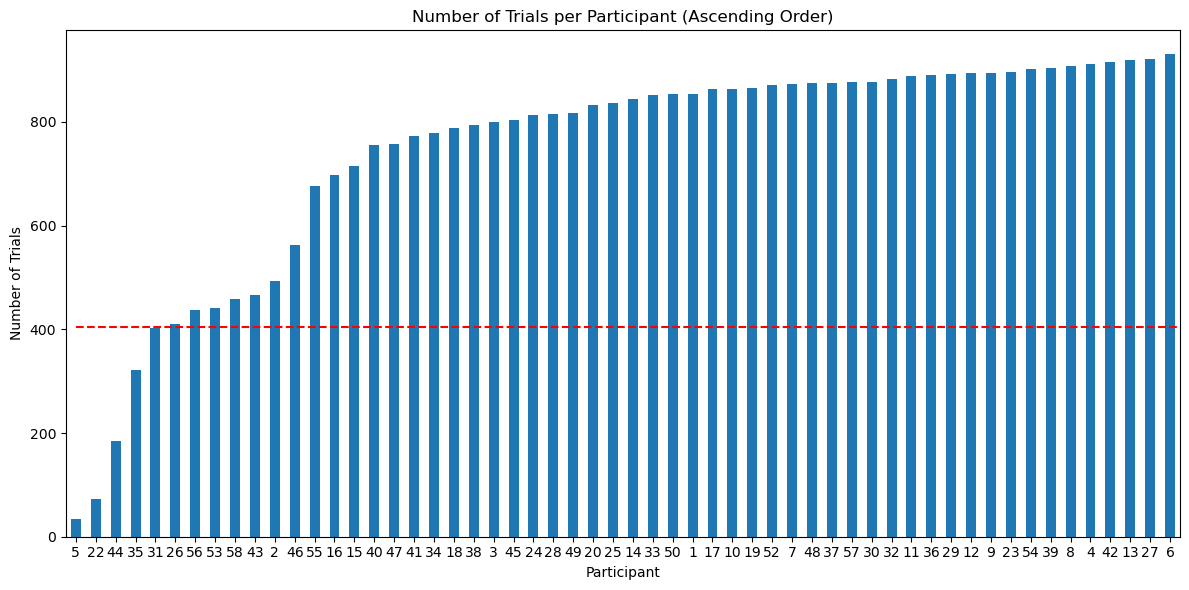

In [3]:
pt_trial = df['pt_num'].value_counts().sort_values(ascending=True)
participants_below_405 = df['pt_num'].value_counts().loc[lambda x: x < 405].index.tolist()
participants_below_405

pt_trial_sorted = pt_trial.sort_values()

plt.figure(figsize=(12, 6))  # Increase the figure size

pt_trial_sorted.plot(kind='bar')
plt.xlabel('Participant')
plt.ylabel('Number of Trials')
plt.title('Number of Trials per Participant (Ascending Order)')
plt.hlines(405, 0, 70, colors='r', linestyles='dashed')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [4]:
#Drop participants with less than 405 trials
df = df[~df['pt_num'].isin(participants_below_405)]


In [5]:
avg_timestamps = df['new_timestamps'].apply(lambda x: np.mean(x)).mean()

def cut_and_fill_traj(traj, length=60, before=10):
    start_index = None
    for i, (x, y) in enumerate(traj):
        if y >= -108:
            start_index = i
            break
    
    if start_index is None:
        return traj[:length]
    beg_index = max(0, start_index - before)
    end_index = start_index + length
    traj = traj[beg_index:end_index]
    
    if (len(traj)-start_index) < end_index:
        last_x, last_y = traj[-1]
        traj.extend([(last_x, last_y)] * (length - len(traj) + before ))
        #traj.extend([(float('nan'), float('nan'))] * (length - len(traj) + before ))
        
    
    return traj

In [6]:
def cut_off_trajectory(traj):
    return [pos for pos in traj if pos[1] >= -108]

df['onset_traj'] = df['downsampled_traj'].apply(cut_off_trajectory)
avg_onset_traj = df['onset_traj'].apply(lambda x: len(x)).mean()
#here we see that the average onset trajectory length is 71 points
# therefore we get 71 points for each trajectory after onset stimuli

In [7]:
df['cut_traj'] = [cut_and_fill_traj(traj, length=71, before=10) for traj in df['downsampled_traj']]
df['x_values'] = df['cut_traj'].apply(lambda traj: [point[0] for point in traj])
df['y_values'] = df['cut_traj'].apply(lambda traj: [point[1] for point in traj])


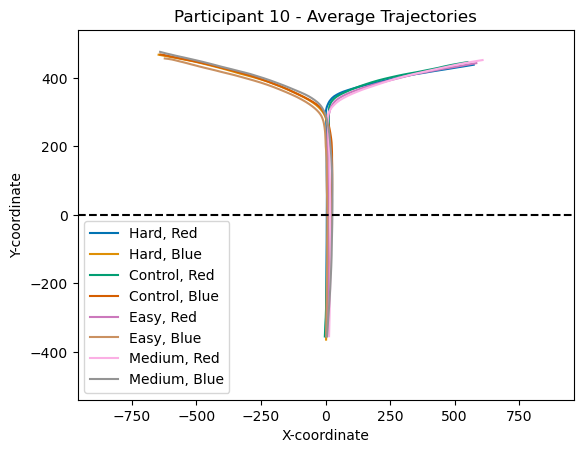

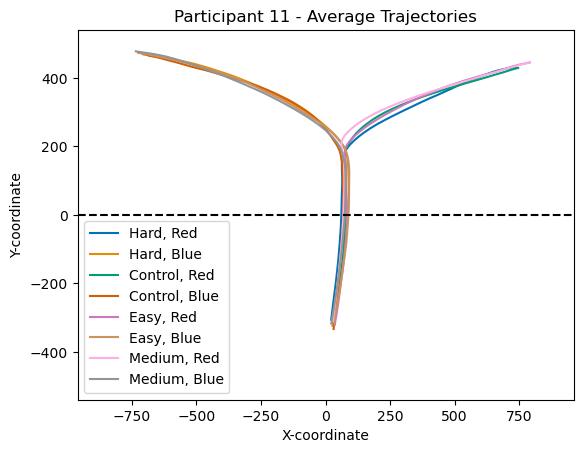

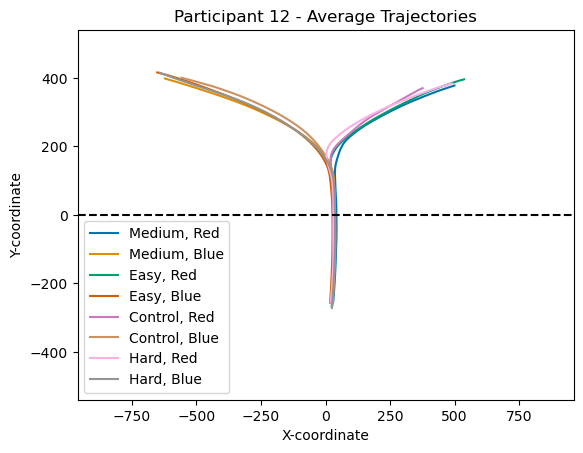

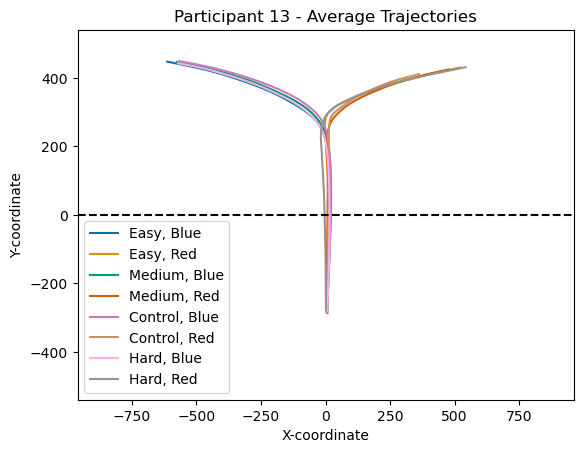

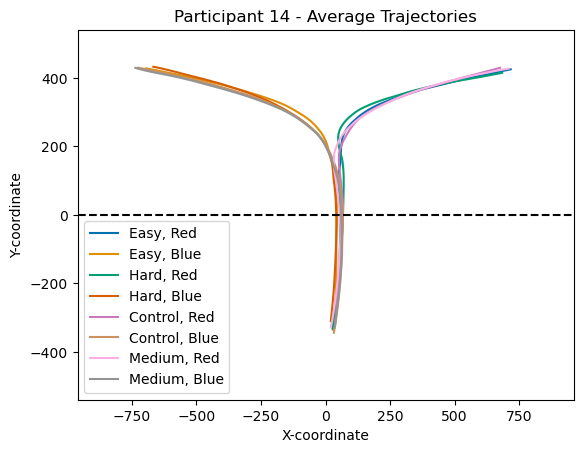

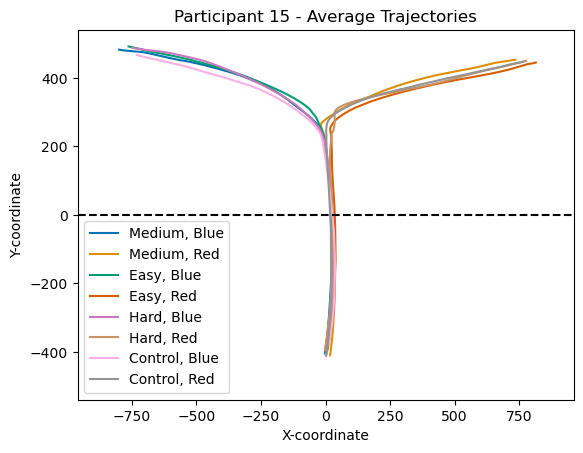

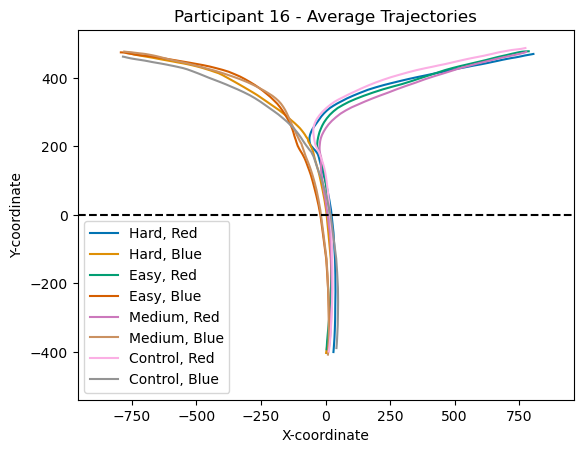

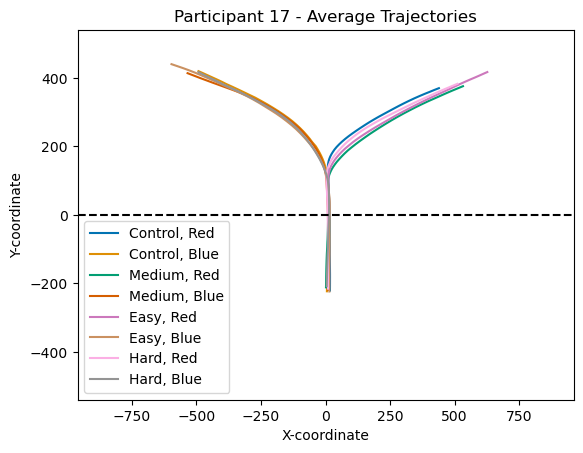

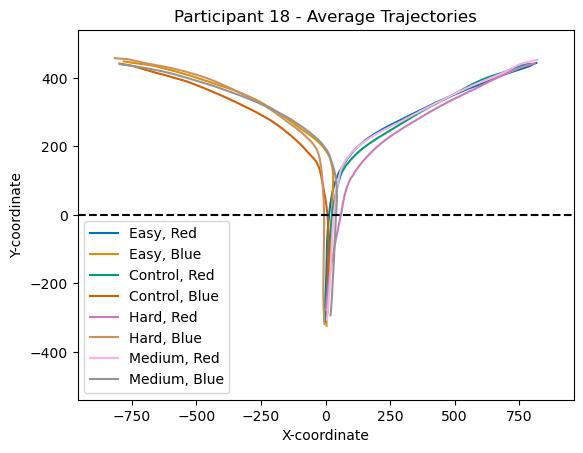

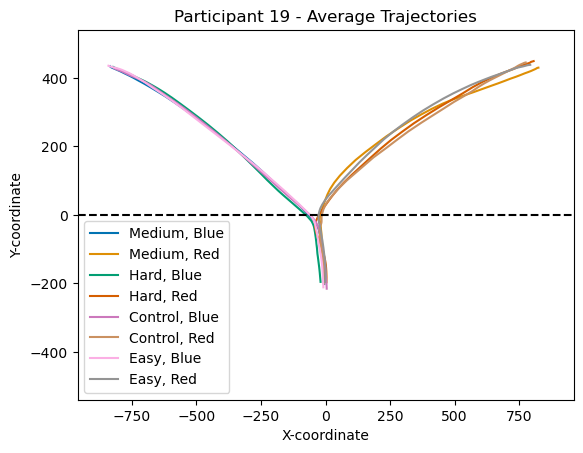

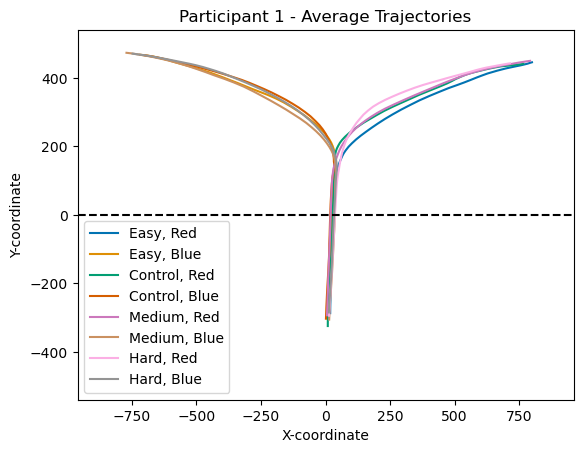

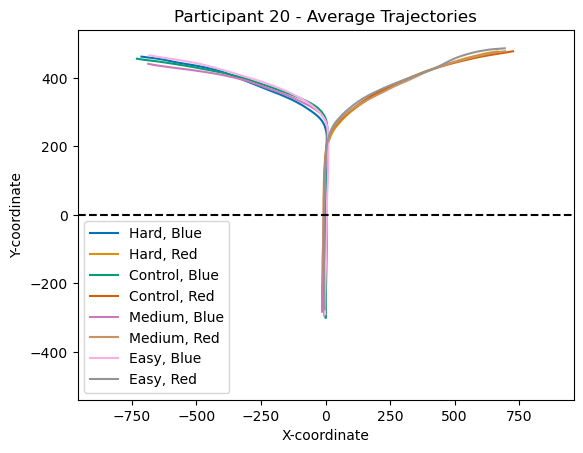

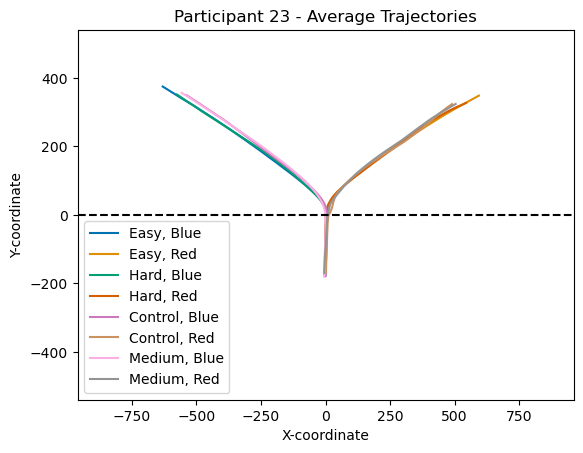

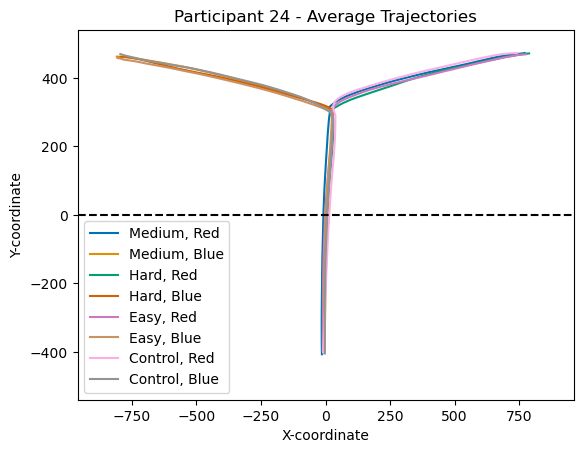

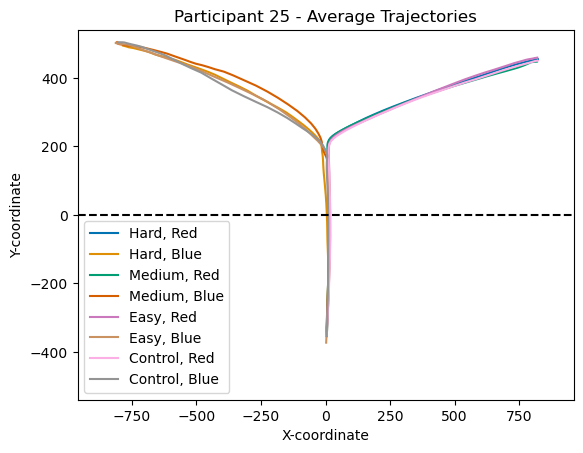

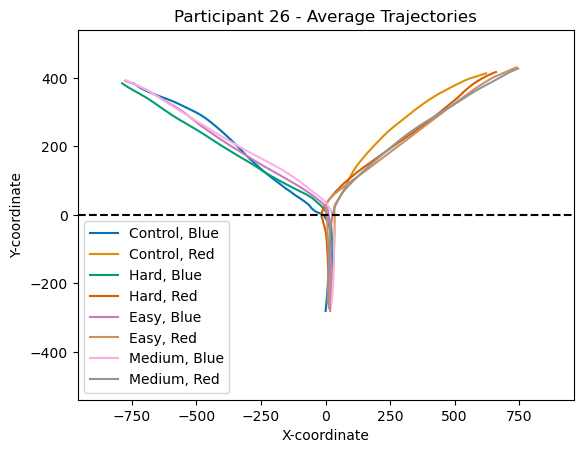

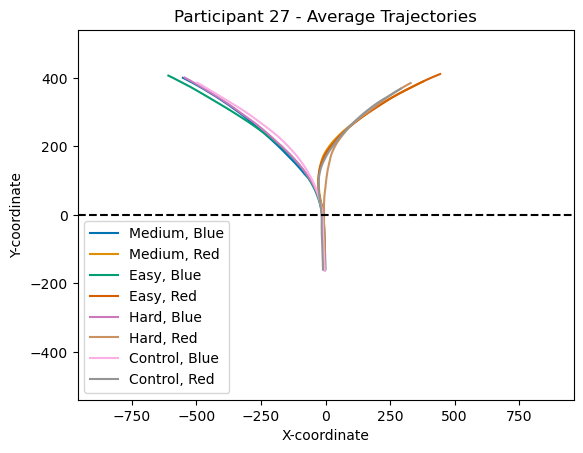

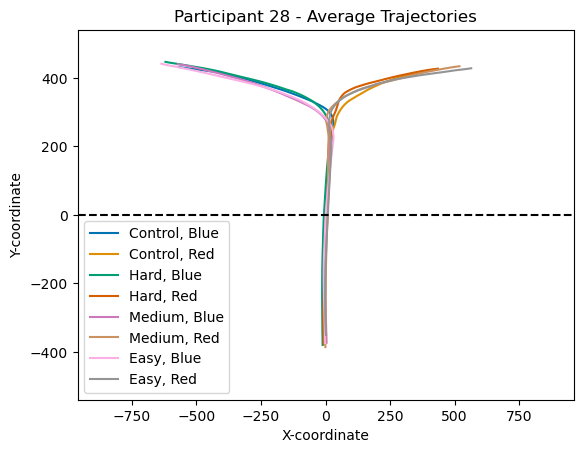

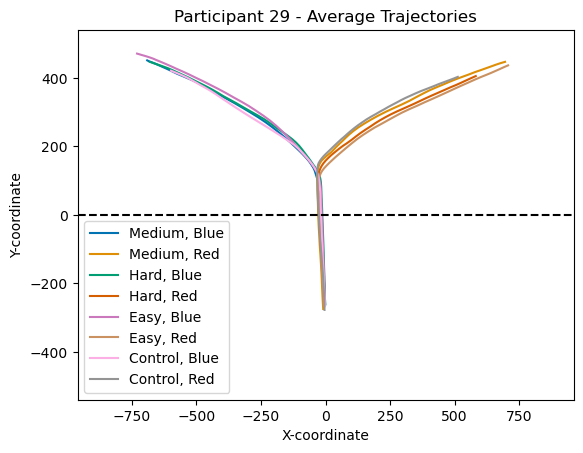

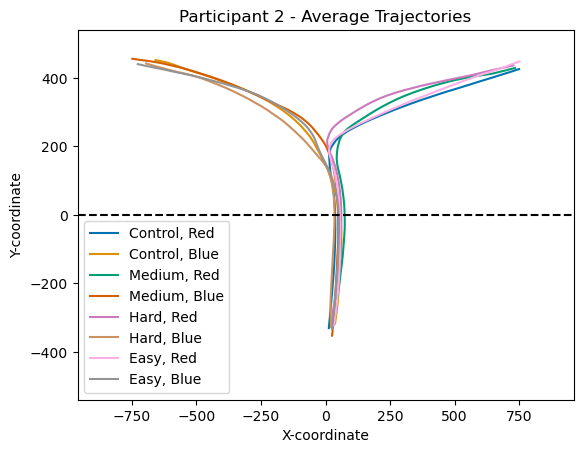

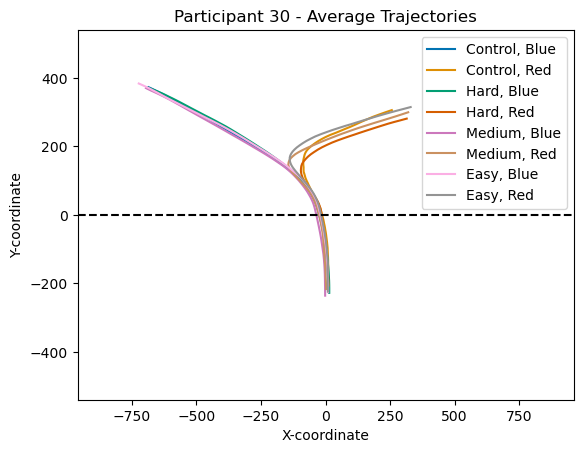

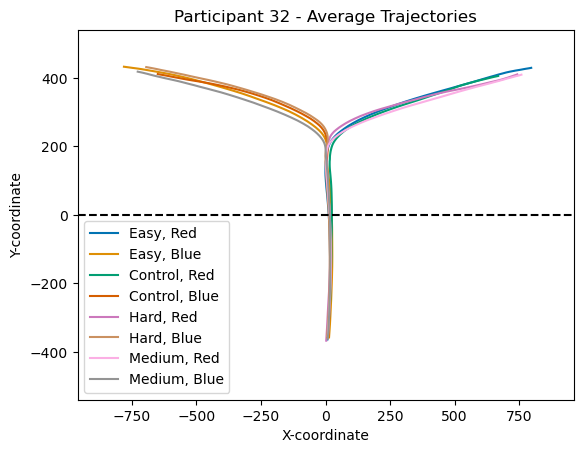

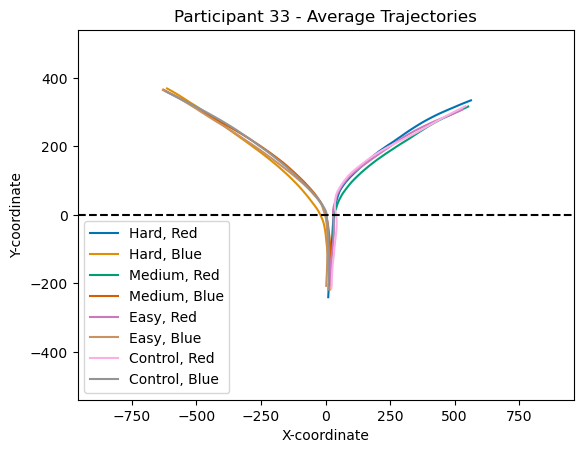

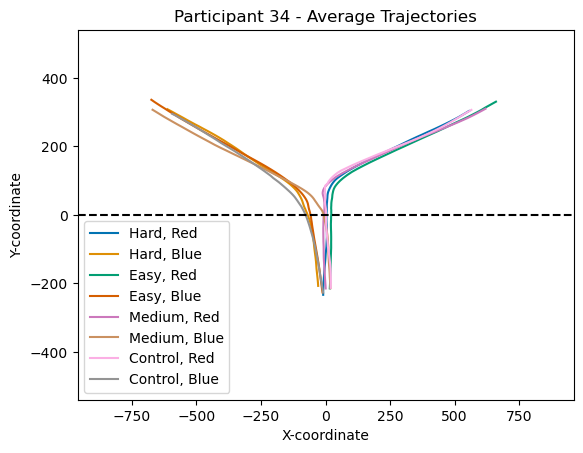

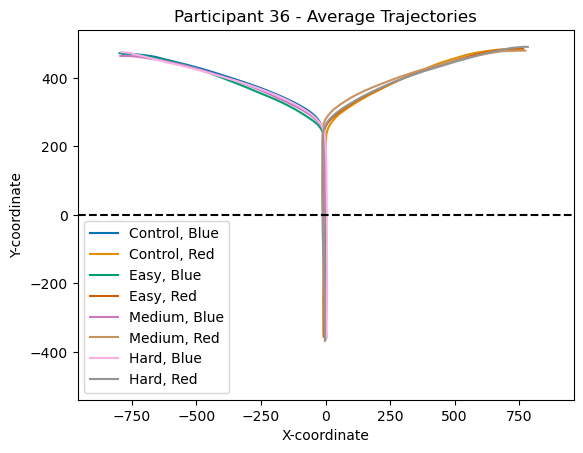

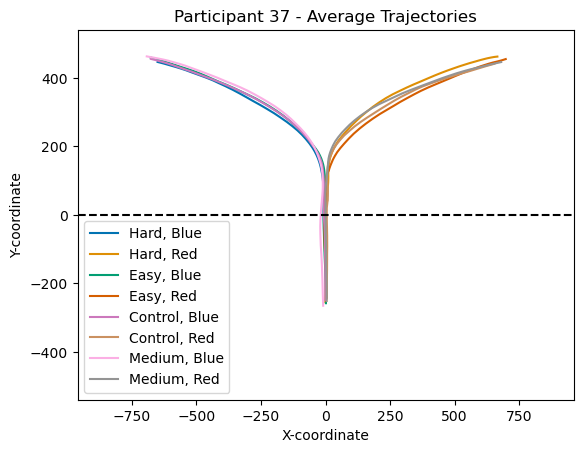

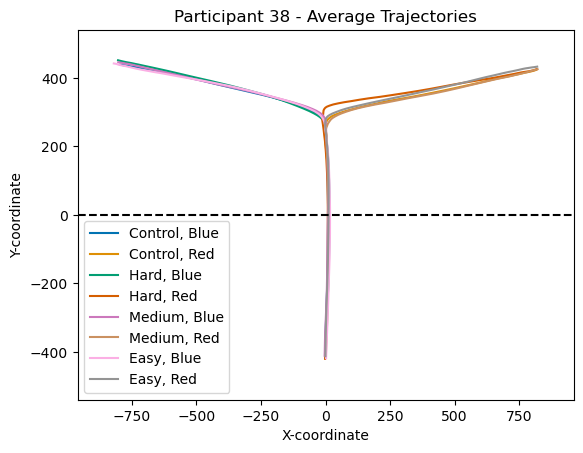

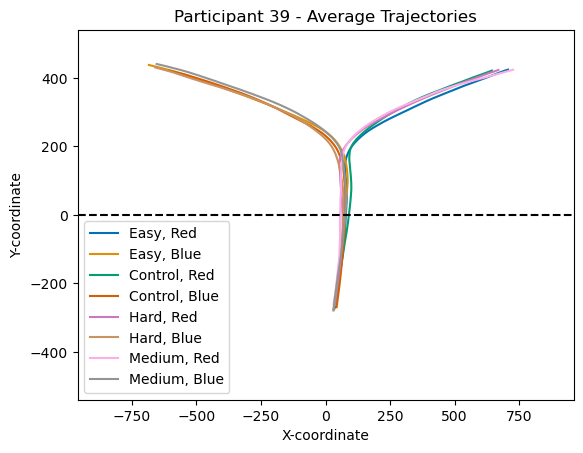

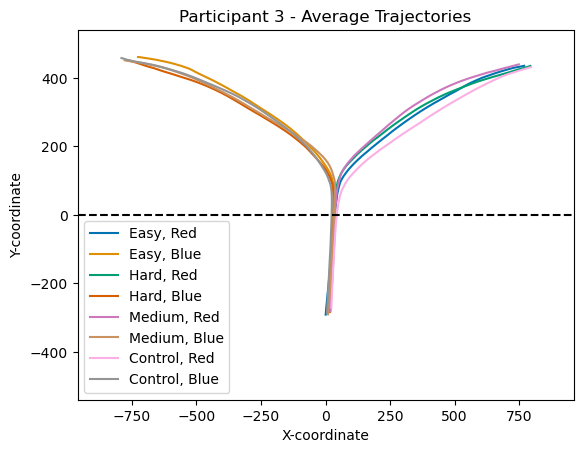

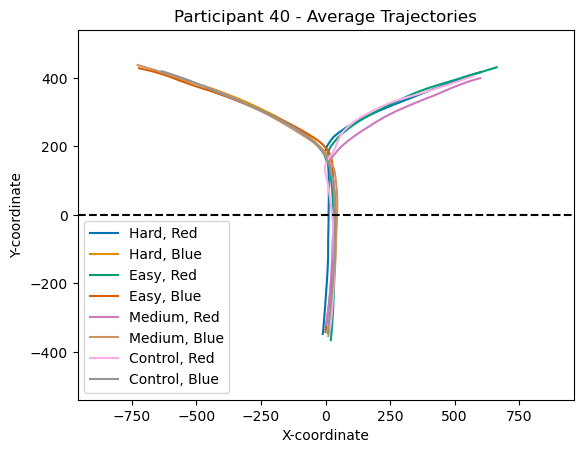

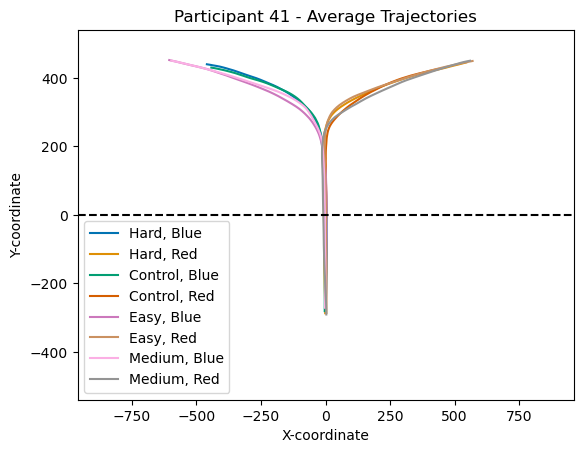

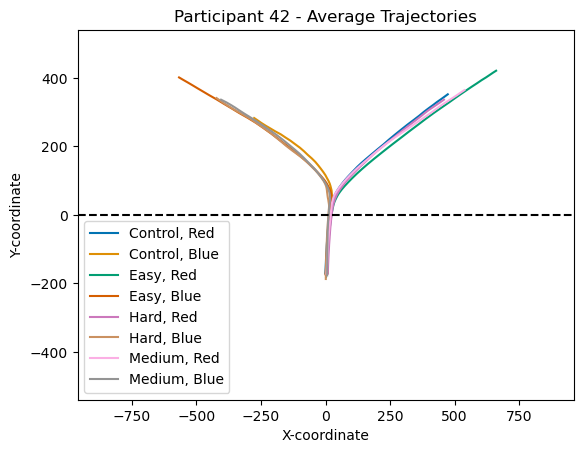

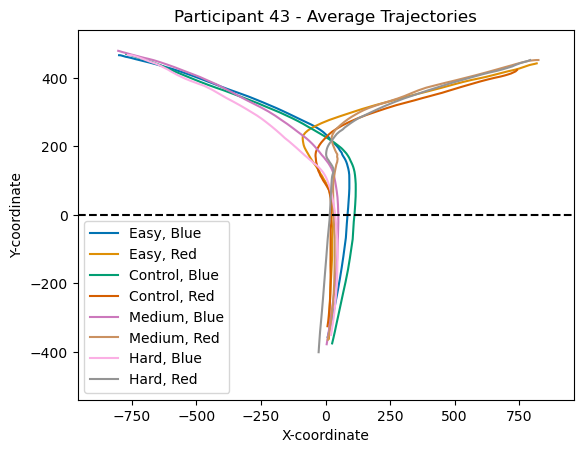

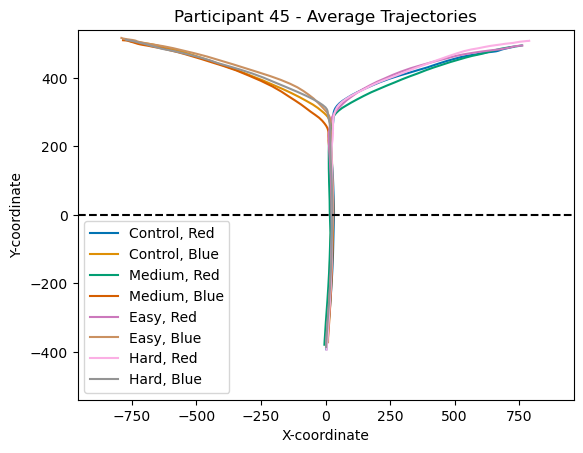

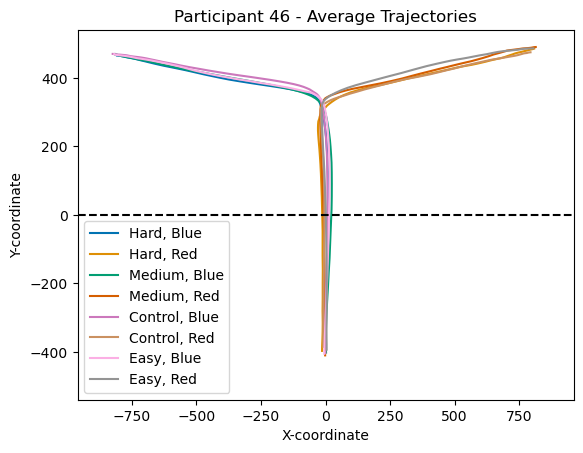

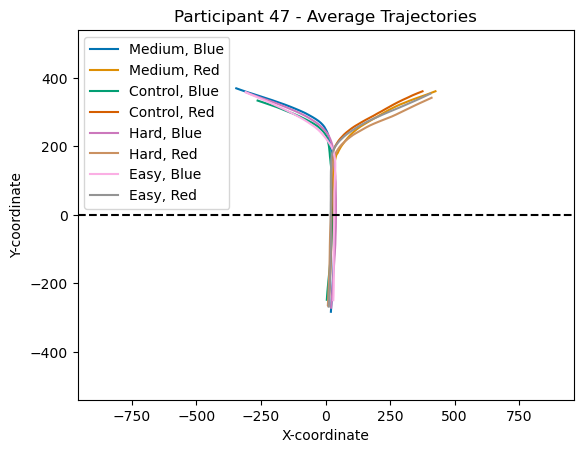

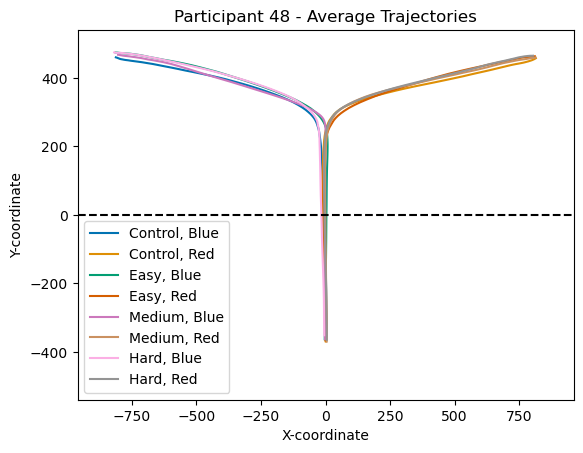

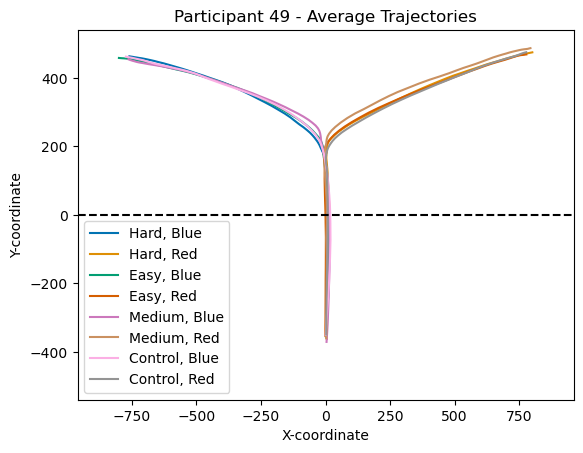

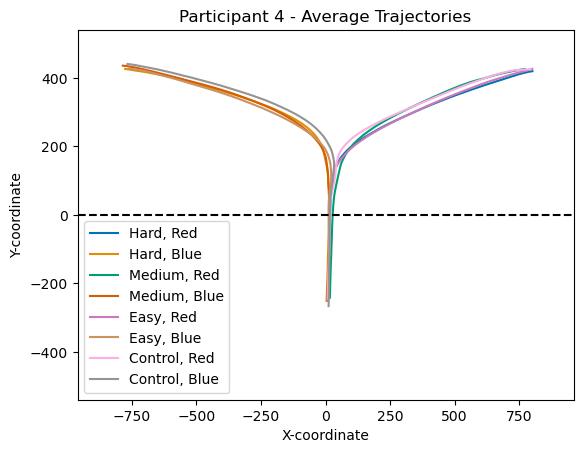

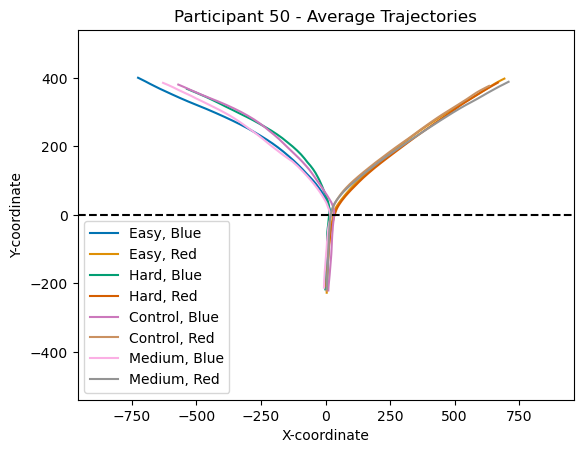

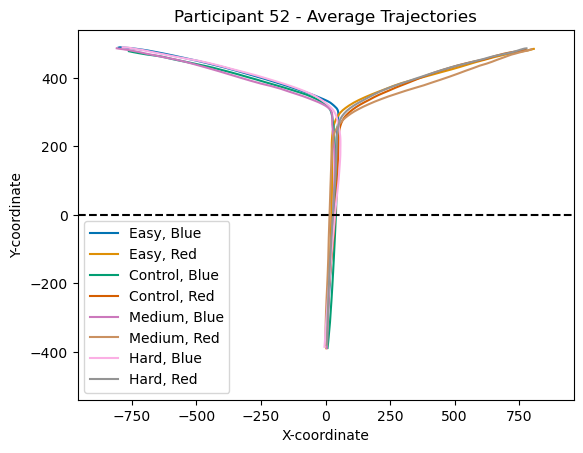

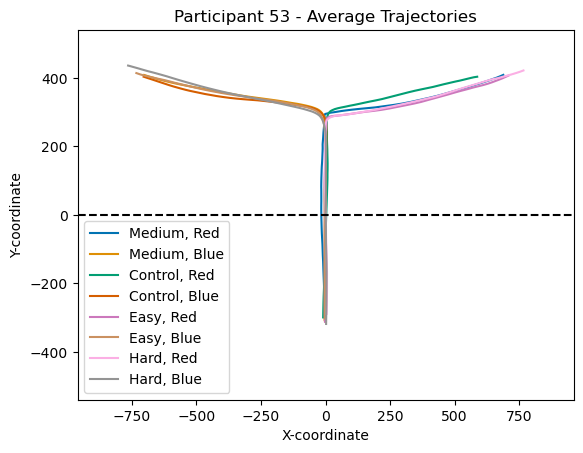

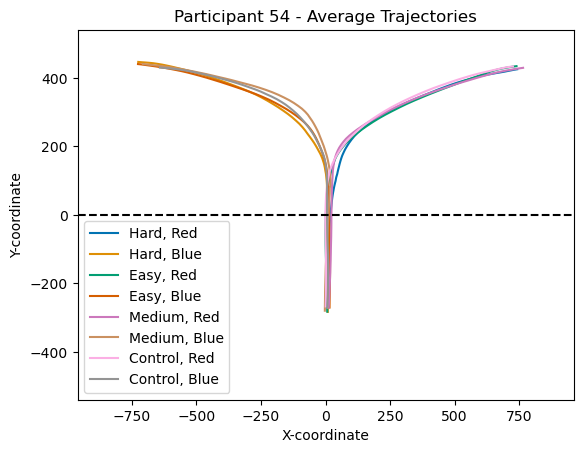

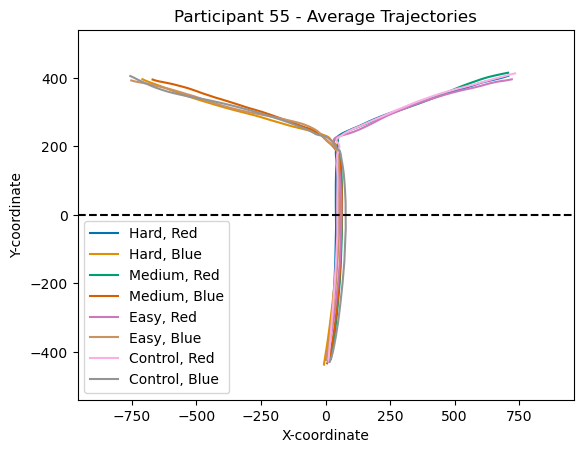

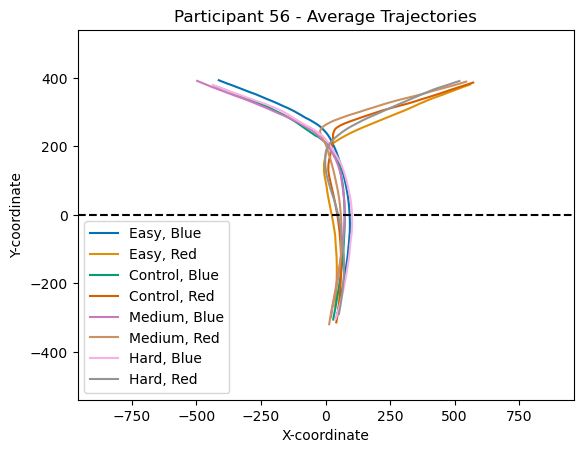

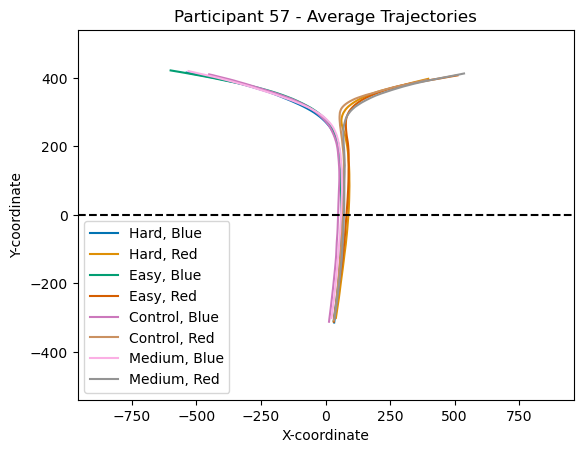

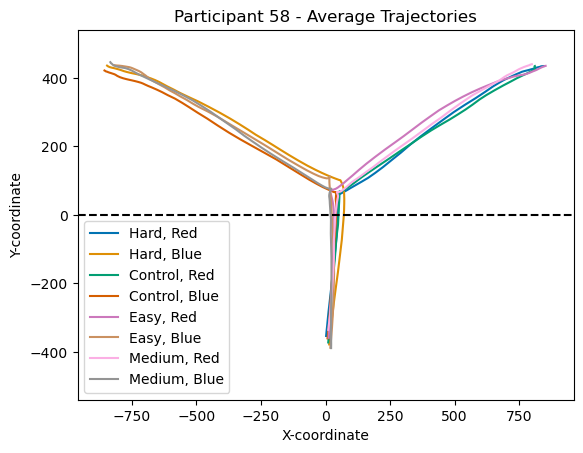

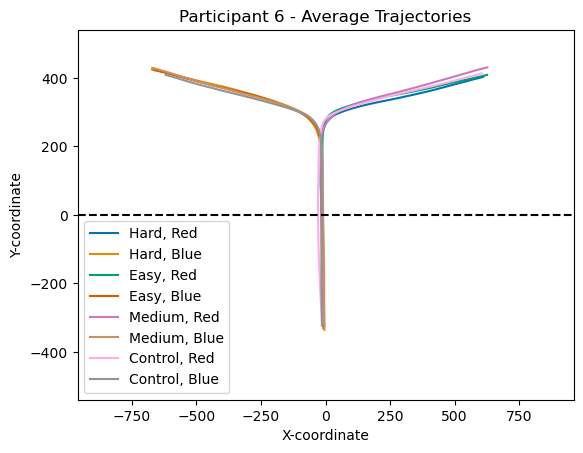

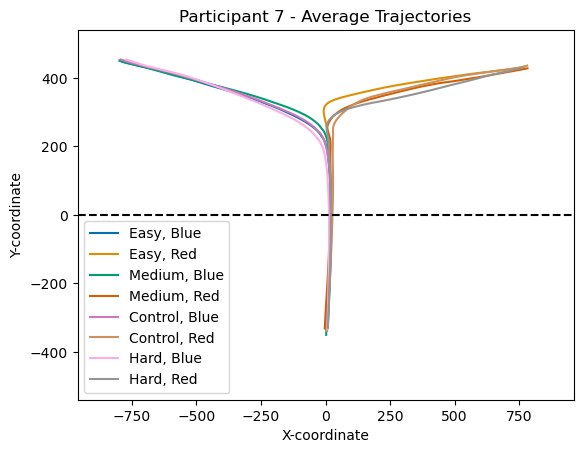

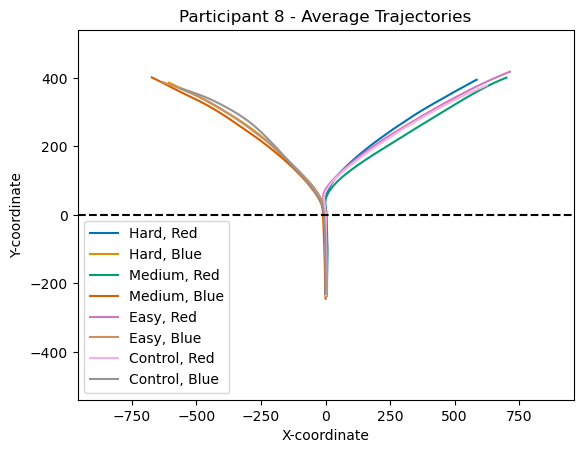

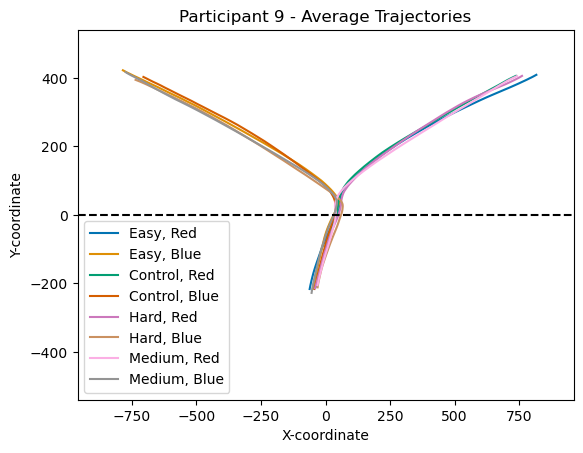

In [8]:
participants = df['pt_num'].unique()

# Set the color palette to colorblind
sns.set_palette("colorblind")

for participant in participants:
    plt.figure()  # Create a new figure for each participant
    
    conditions = df[df['pt_num'] == participant]['difficulty'].unique()
    choices = df[df['pt_num'] == participant]['choice'].unique()
    
    for condition in conditions:
        for choice in choices:
            df_filtered = df[(df['pt_num'] == participant) & (df['difficulty'] == condition) & (df['choice'] == choice)]
            
            average_x_traj = np.nanmean(df_filtered['x_values'].tolist(), axis=0)
            average_y_traj = np.nanmean(df_filtered['y_values'].tolist(), axis=0)
            
            plt.plot(average_x_traj, average_y_traj, label=f'{condition}, {choice}')
    
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.xlim(-960, 960)
    plt.ylim(-540, 540)
    plt.hlines(0, -960, 960, colors='black', linestyles='dashed')
    plt.title(f'Participant {participant} - Average Trajectories')
    plt.legend()
    #plt.savefig(f'interim plots_1/participant_{participant}_nan_avg.pdf')
    plt.show()
    plt.close()

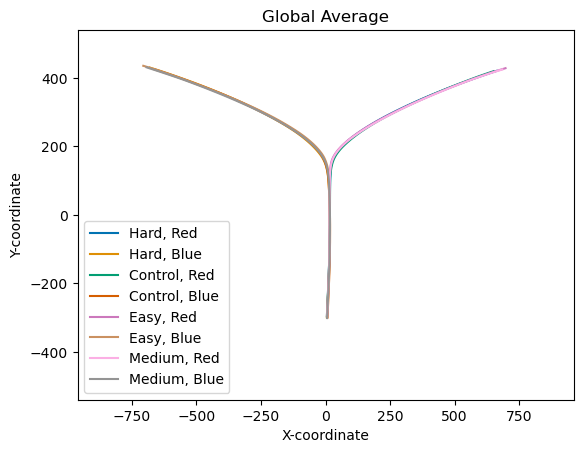

In [9]:
conditions = df['difficulty'].unique()
choices = df['choice'].unique()

for condition in conditions:
    for choice in choices:
        df_filtered = df[(df['difficulty'] == condition) & (df['choice'] == choice)]

        average_x_traj = np.nanmean(df_filtered['x_values'].tolist(), axis=0)
        average_y_traj = np.nanmean(df_filtered['y_values'].tolist(), axis=0)

        plt.plot(average_x_traj, average_y_traj, label=f'{condition}, {choice}')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.xlim(-960, 960)
plt.ylim(-540, 540)
#plt.hlines(-108, -960, 960, colors='black', linestyles='dashed')
plt.title('Global Average')
plt.legend()
#plt.savefig('interim plots_1/0global_avg_nan.pdf')
plt.show()



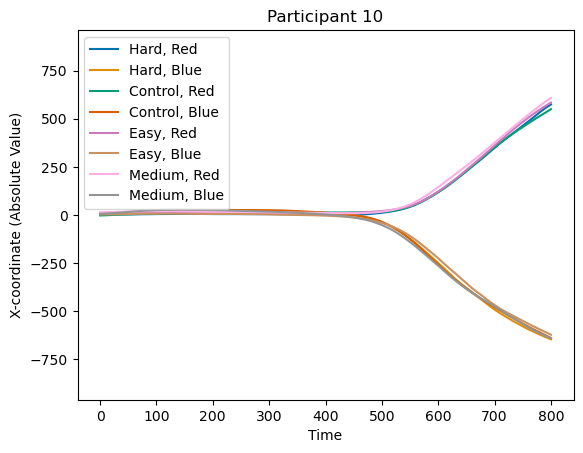

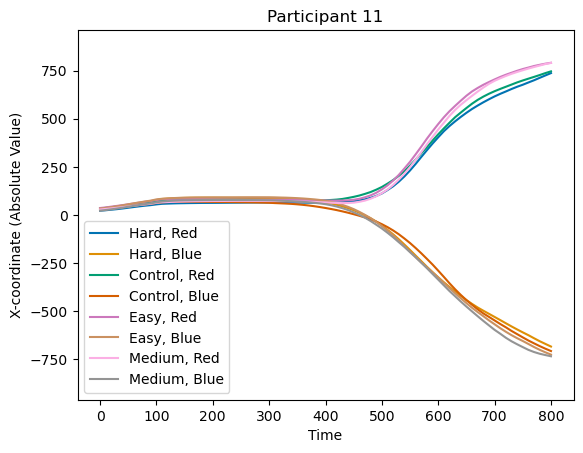

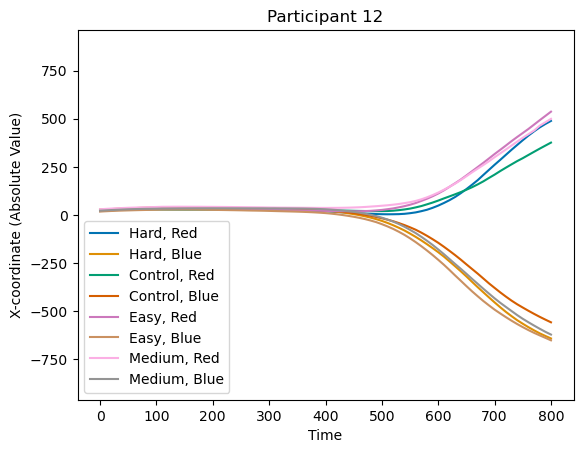

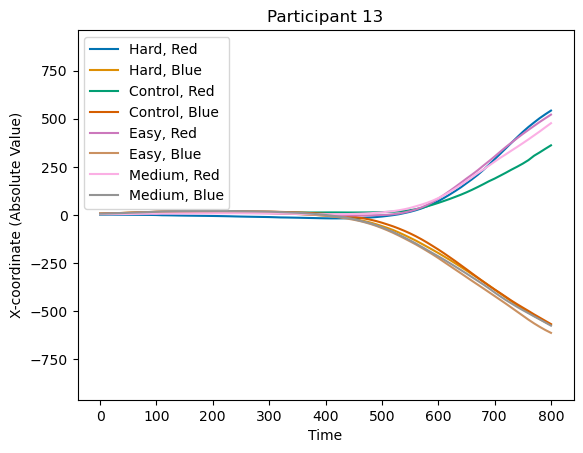

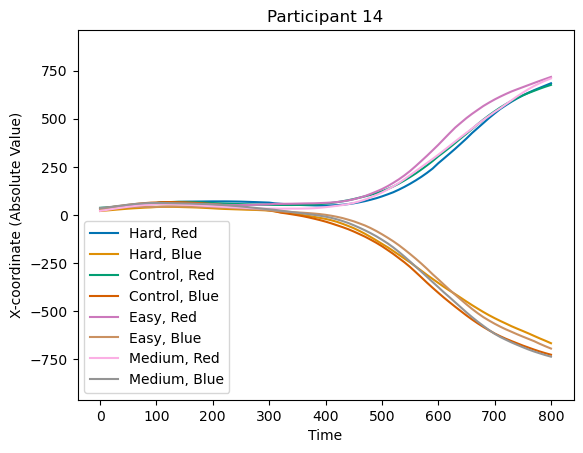

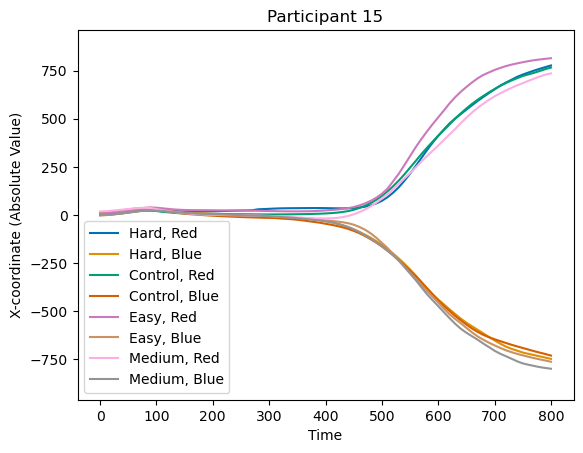

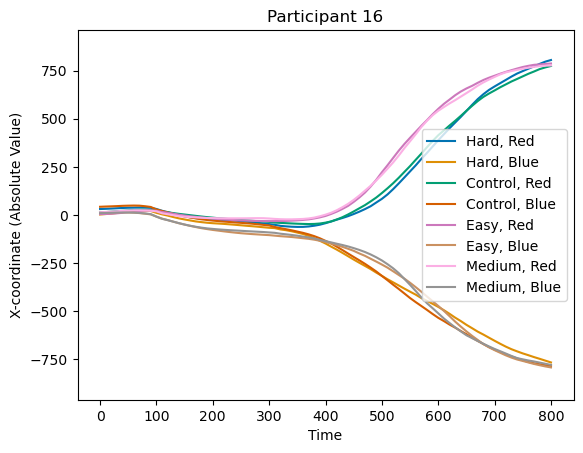

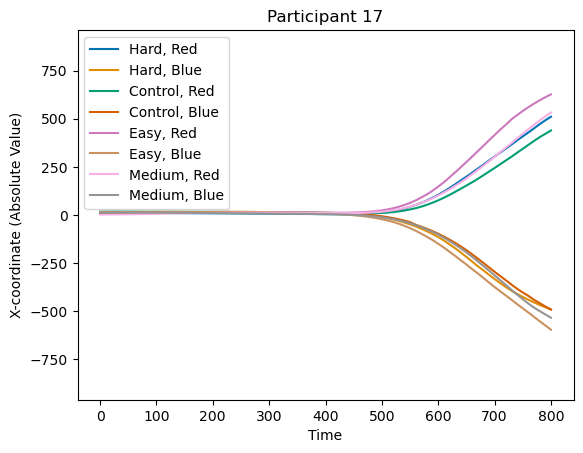

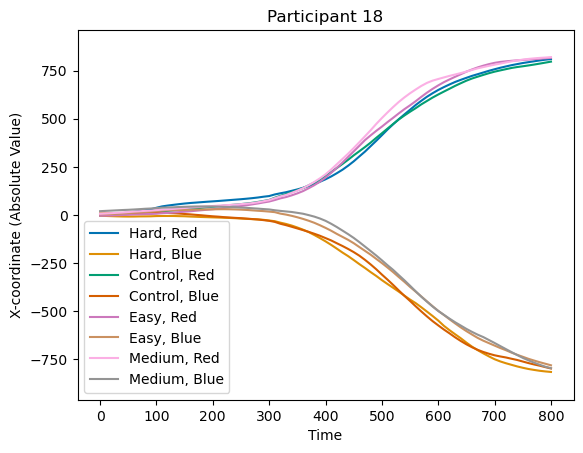

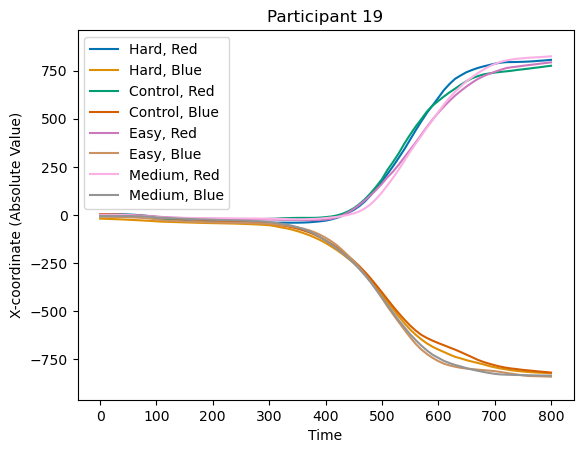

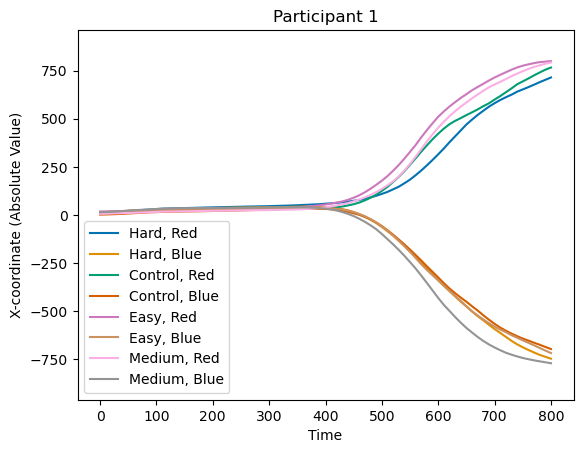

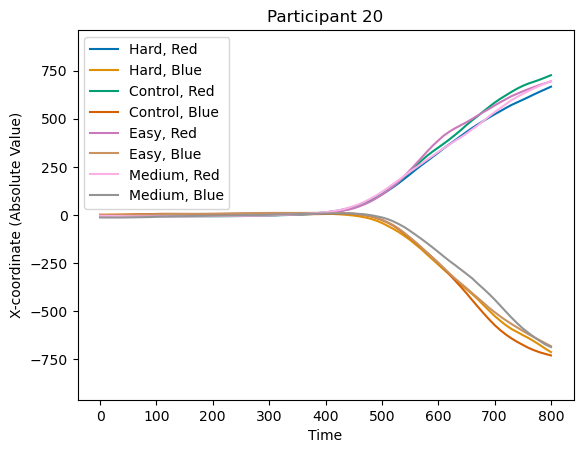

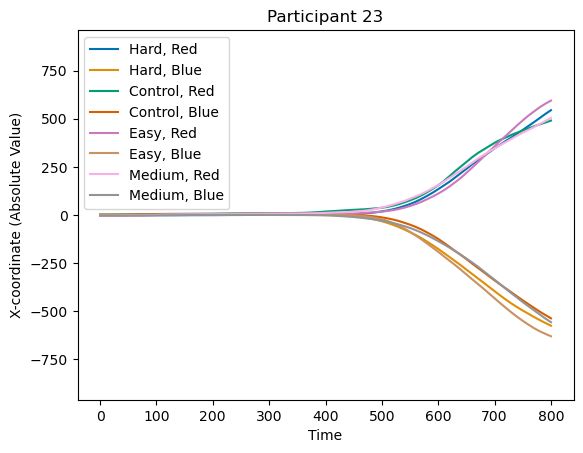

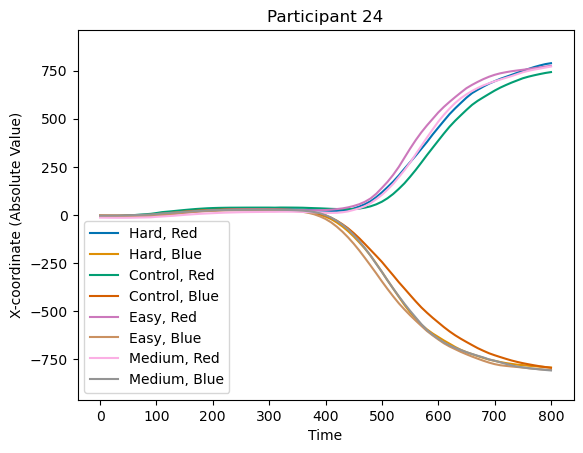

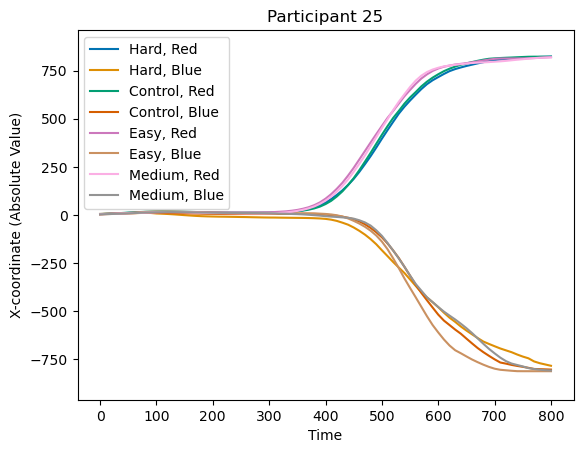

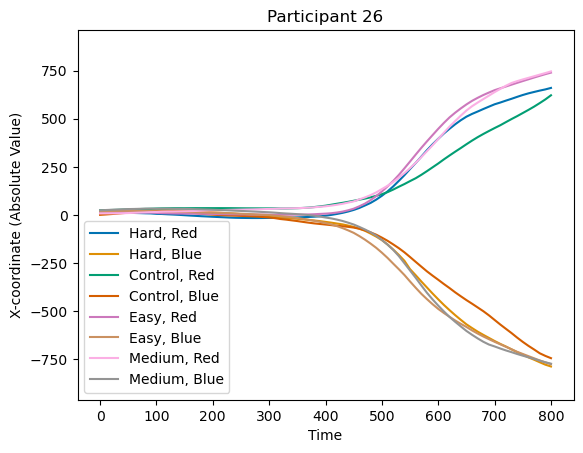

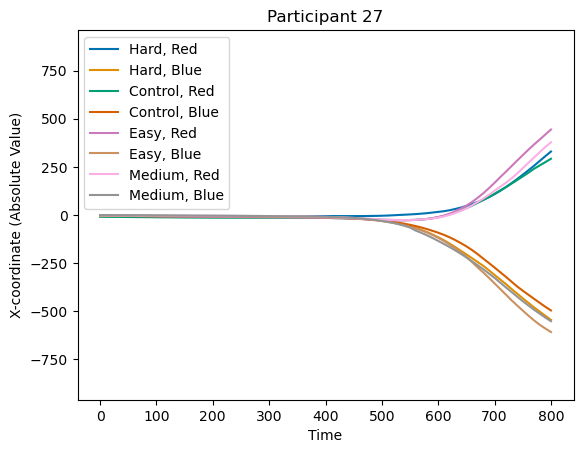

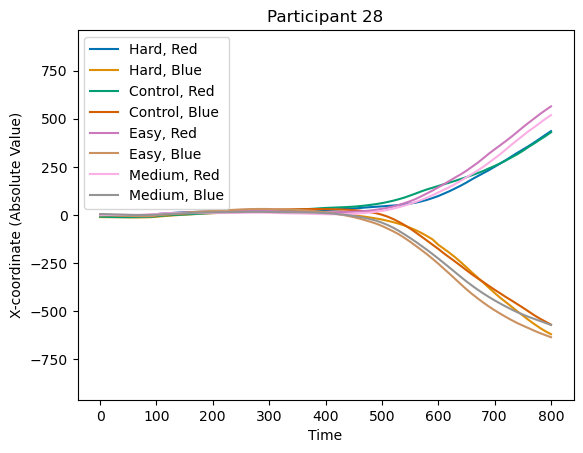

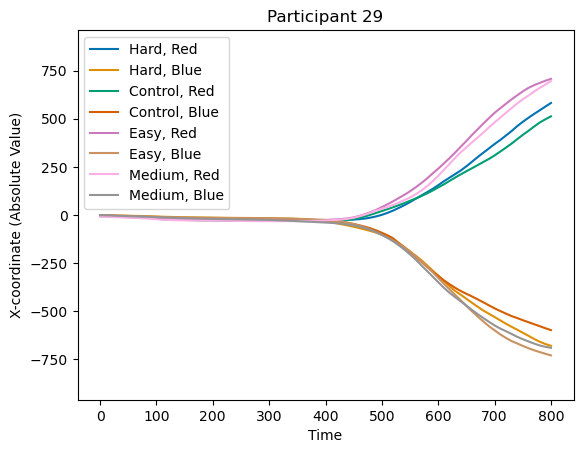

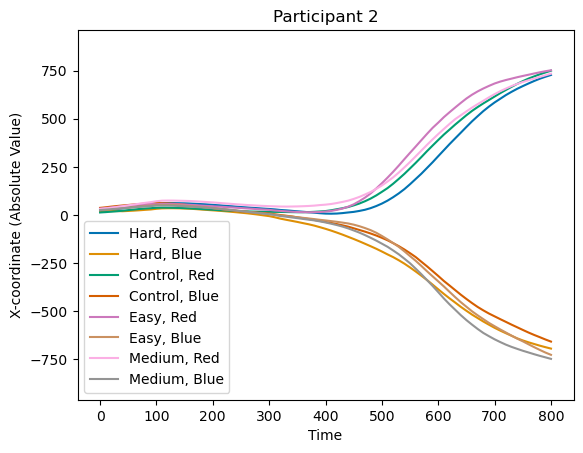

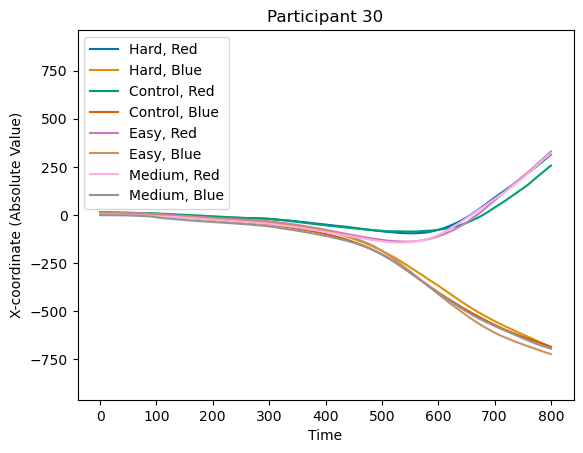

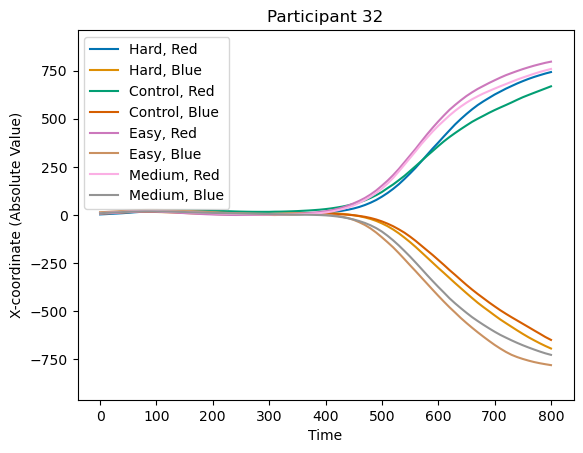

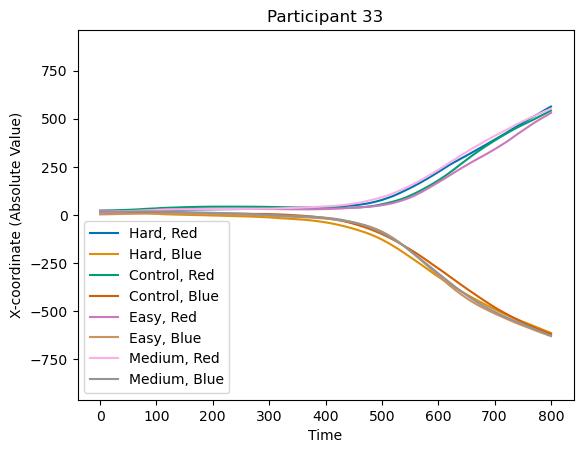

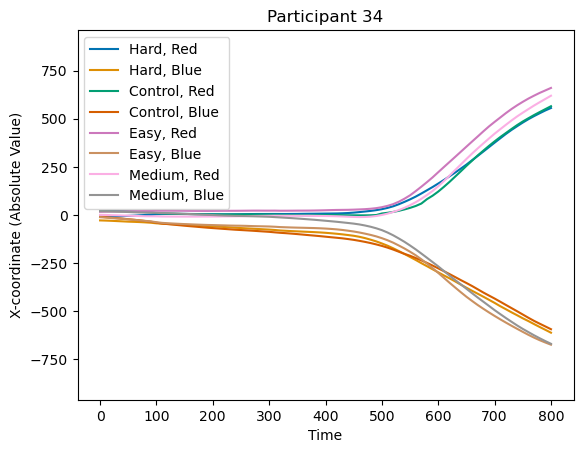

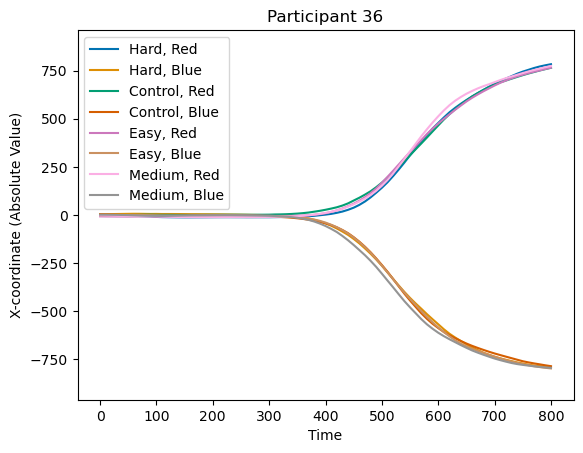

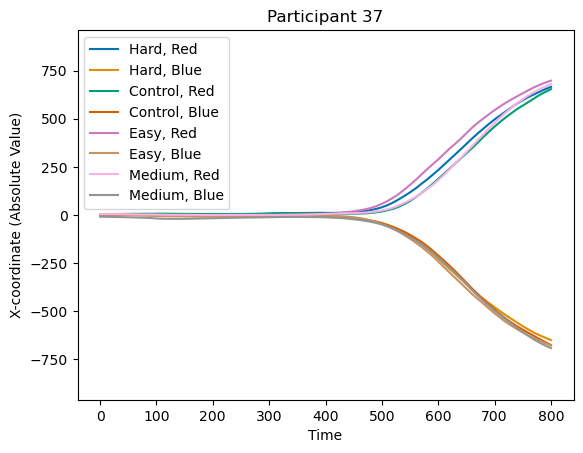

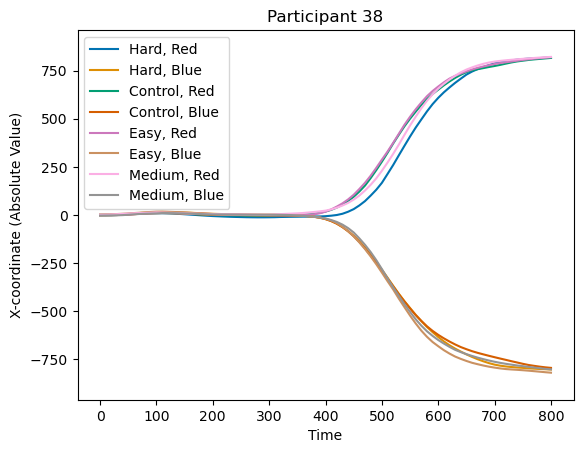

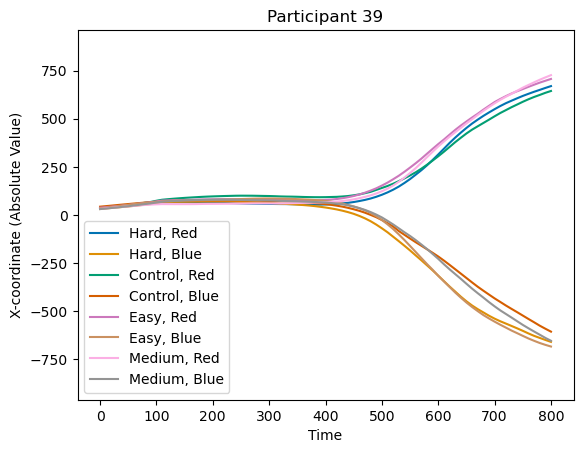

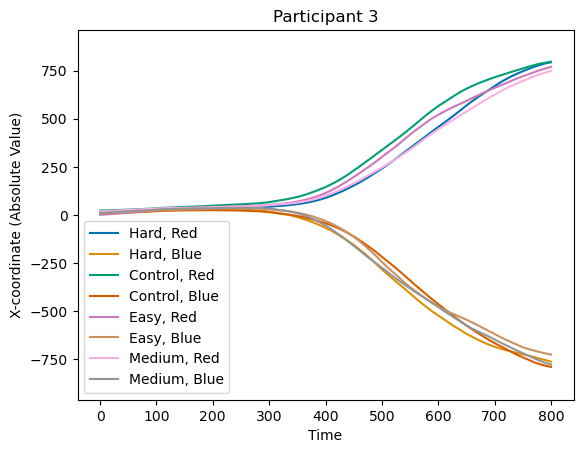

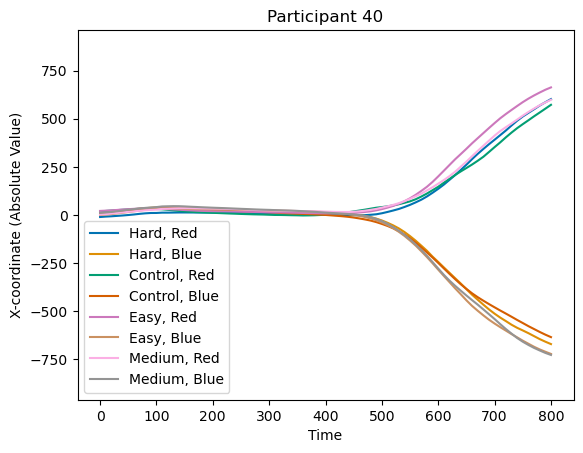

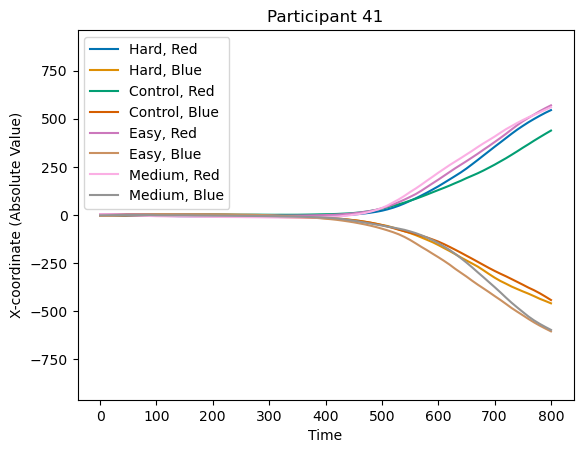

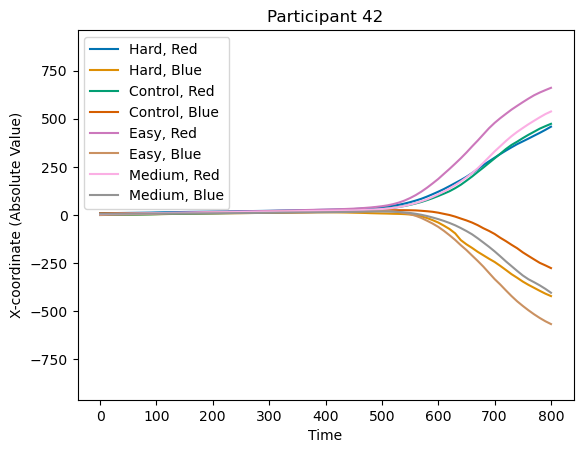

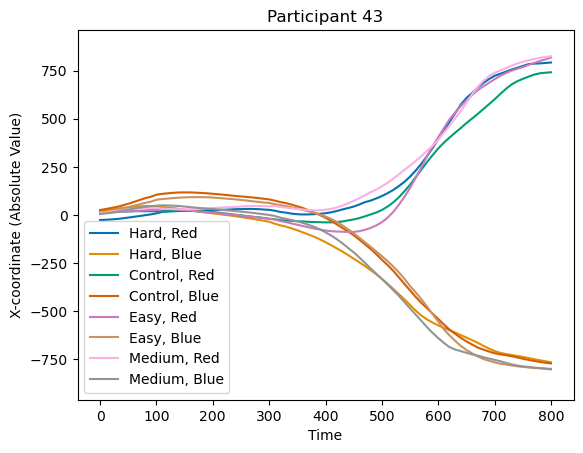

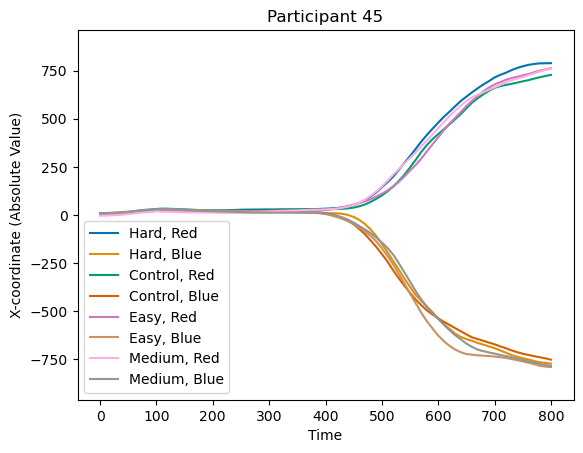

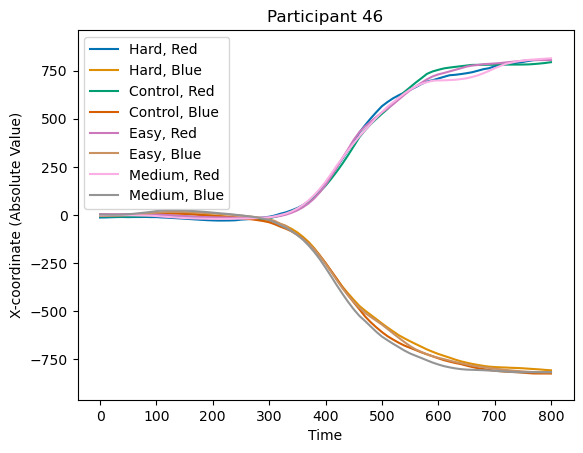

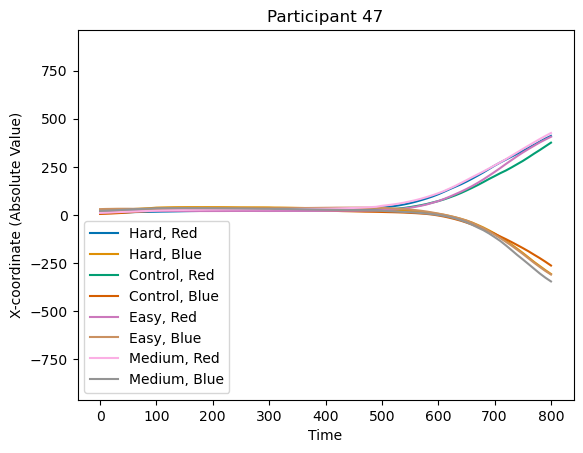

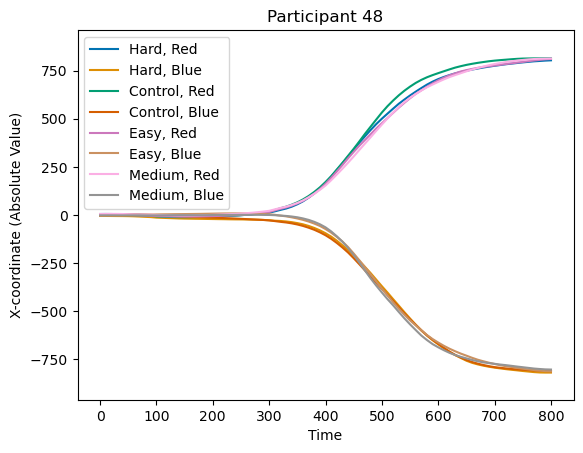

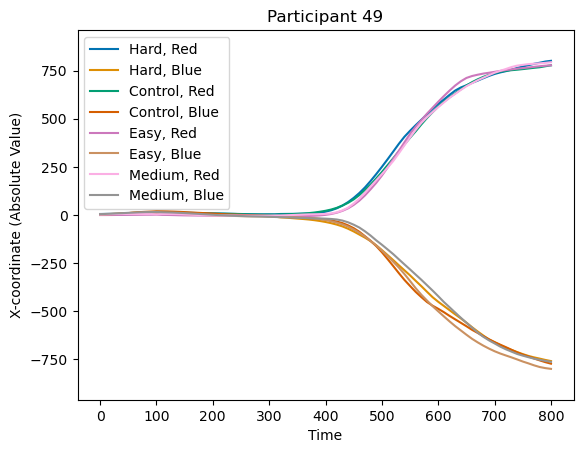

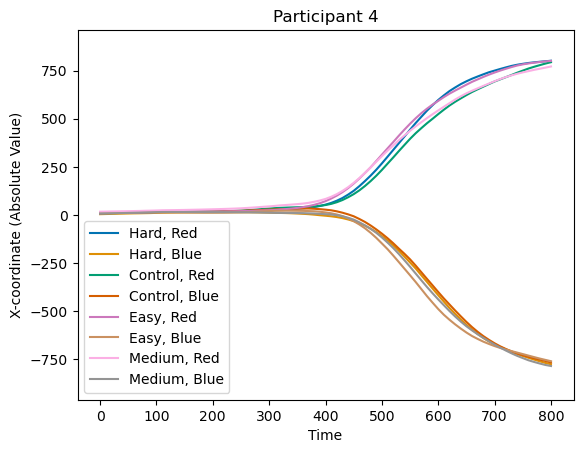

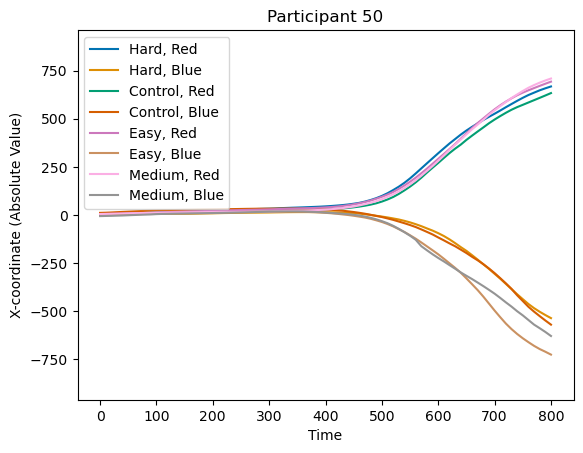

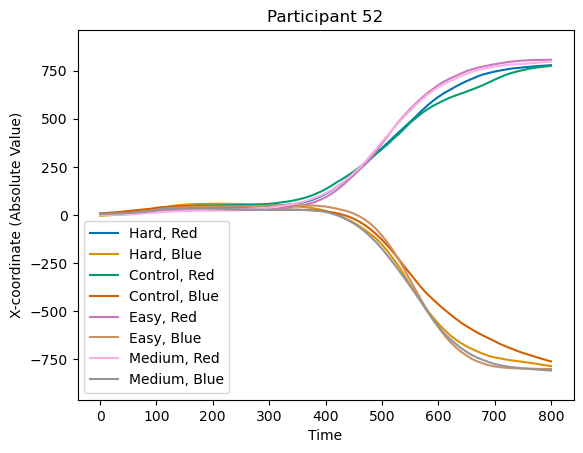

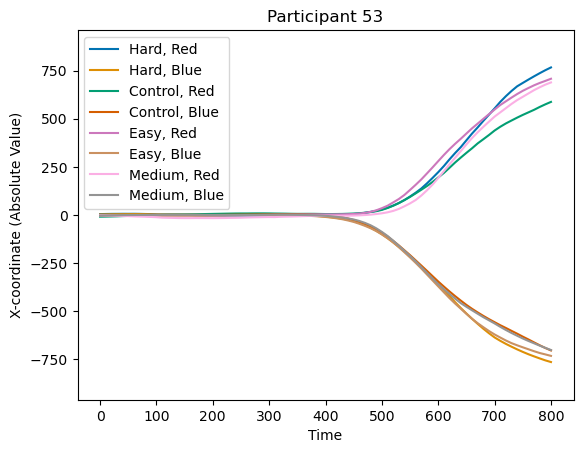

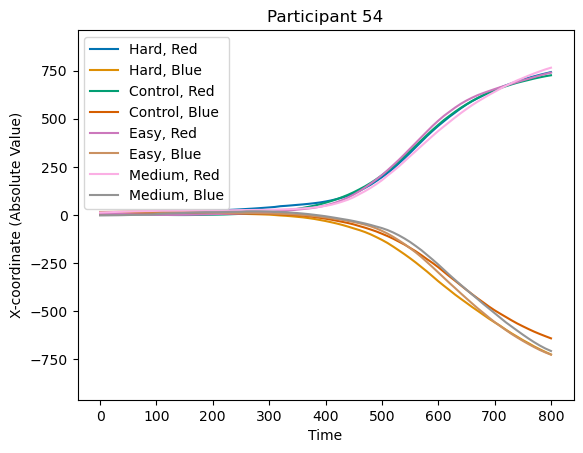

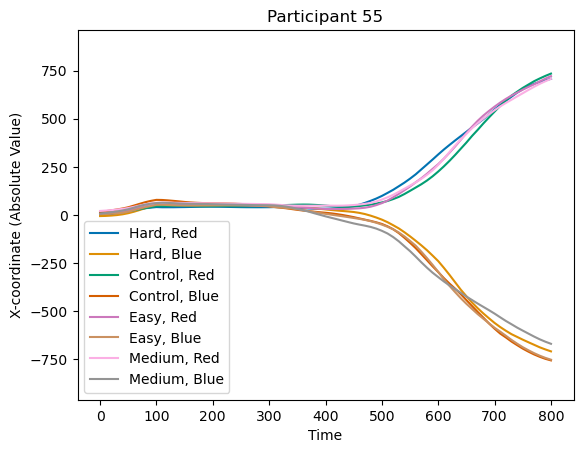

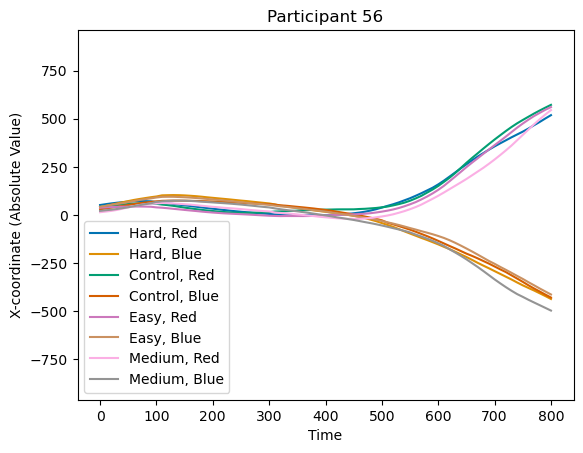

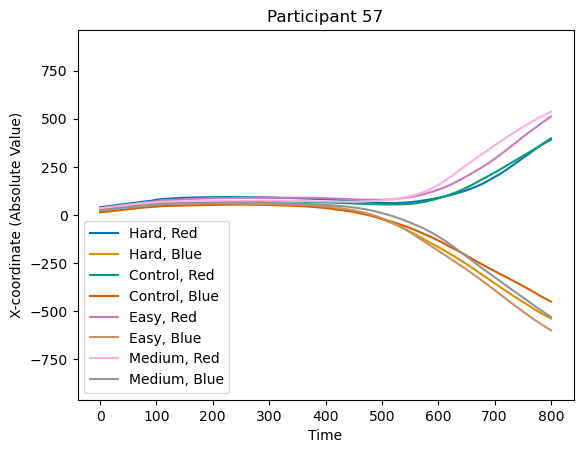

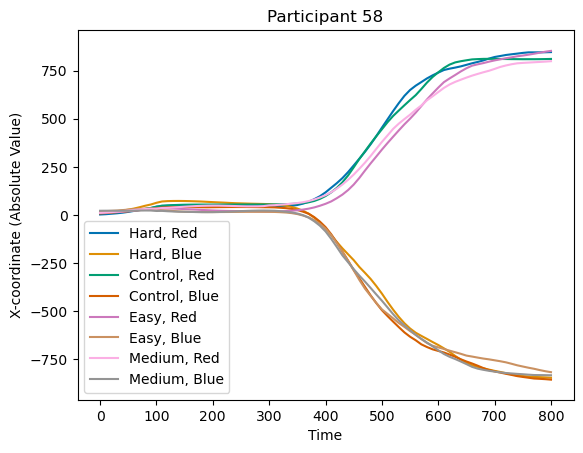

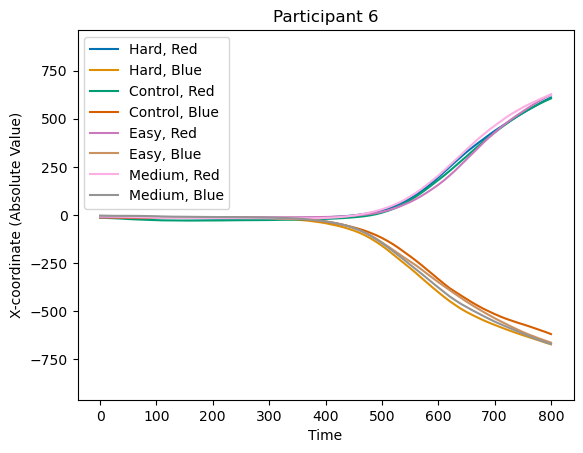

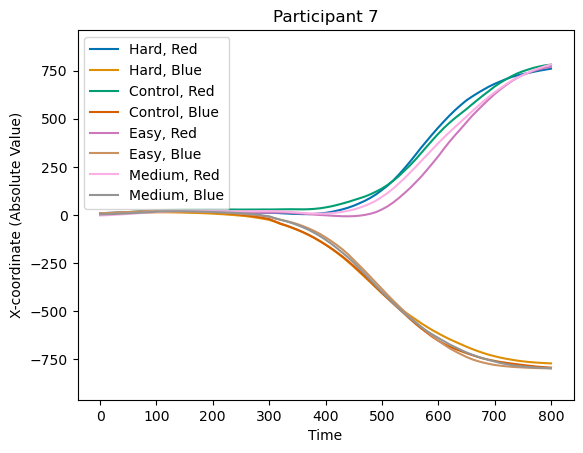

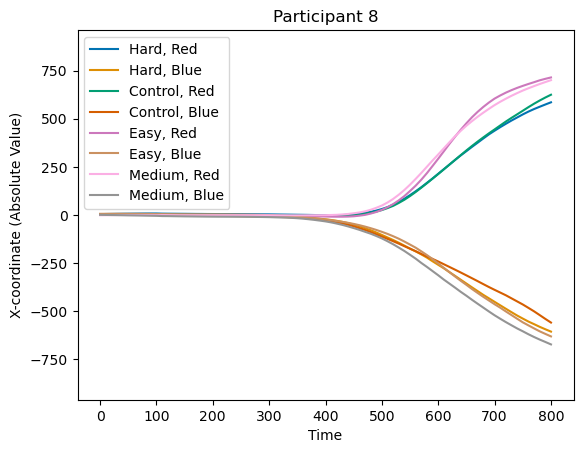

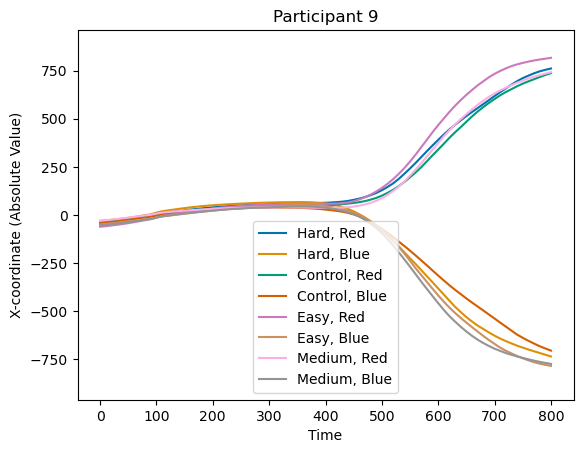

In [10]:
participants = df['pt_num'].unique()
conditions = df['difficulty'].unique()
sns.set_palette("colorblind")
for participant in participants:
    fig, ax = plt.subplots()  # Create a new figure and axes for each participant
    
    for condition in conditions:
        df_filtered = df[(df['pt_num'] == participant) & (df['difficulty'] == condition)]
        
        for choice in choices:
            df_choice_filtered = df_filtered[df_filtered['choice'] == choice]
            
            if choice == 'Red':
                average_x_traj = np.nanmean(df_choice_filtered['x_values'].tolist(), axis=0)
                time = list(range(0, len(average_x_traj) * 10, 10))
                ax.plot(time, average_x_traj,label=f'{condition}, {choice}')
                ax.set_xlabel('Time')
                ax.set_ylabel('X-coordinate')
                ax.set_title(f'Participant {participant}')
            elif choice == 'Blue':
                average_x_traj = np.nanmean(df_choice_filtered['x_values'].tolist(), axis=0)
                #average_x_traj_abs = np.abs(average_x_traj)
                ax.plot(time, average_x_traj, label=f'{condition}, {choice}')
                ax.set_xlabel('Time')
                ax.set_ylabel('X-coordinate (Absolute Value)')
                ax.set_title(f'Participant {participant}')
    
    ax.set_ylim(-960, 960)
    ax.legend()
    #plt.savefig(f'interim plots_2/participant_{participant}_lastpoint_x_seperation.pdf')
    plt.show()


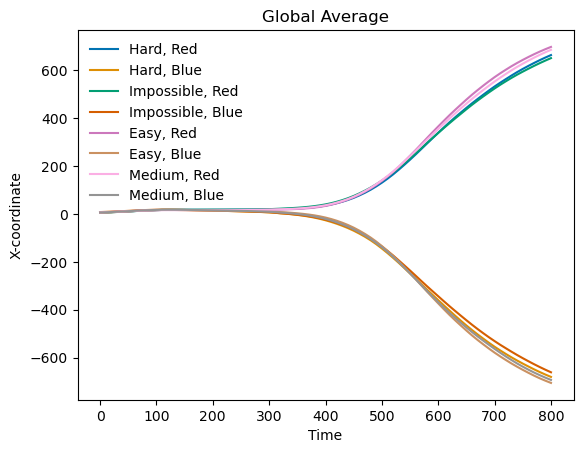

In [15]:
conditions = df['difficulty'].unique()
choices = df['choice'].unique()

plt.figure()  # Create a new figure

for condition in conditions:
    for choice in choices:
        df_filtered = df[(df['difficulty'] == condition) & (df['choice'] == choice)]

        average_x_traj = np.nanmean(df_filtered['x_values'].tolist(), axis=0)

        plt.plot(time, average_x_traj, label=f'{condition}, {choice}')

plt.ylabel('X-coordinate')
plt.xlabel('Time')
plt.title('Global Average')
plt.legend(labels=['Hard, Red', 'Hard, Blue', 'Impossible, Red', 'Impossible, Blue', 'Easy, Red', 'Easy, Blue', 'Medium, Red', 'Medium, Blue'], framealpha=0)
plt.savefig("plot_avg.png", transparent=True, dpi=1000)


#plt.savefig('interim plots_2/0global_lastpoint_xseperation.pdf')
plt.show()


In [12]:
participants = df['pt_num'].unique()
conditions = df['difficulty'].unique()
choices = df['choice'].unique()

n_df = pd.DataFrame(columns=['participant', 'difficulty', 'choice', 'average_x_traj'])
for participant in participants:
    for condition in conditions:
        for choice in choices:
            df_filtered = df[(df['pt_num'] == participant) & (df['difficulty'] == condition) & (df['choice'] == choice)]

            last_x = df_filtered['x-coordinates'].iloc[-1]
            n_df.loc[len(n_df)] = [participant, condition, choice, average_x_traj]

            # Continue with your plotting or analysis here

KeyError: 'x-coordinates'

One-way ANOVA results for Blue:
       Source             SS   DF            MS          F         p-unc  \
0  difficulty   60801.739973    3  20267.246658  19.003905  1.685350e-10   
1       Error  159971.701097  150   1066.478007        NaN           NaN   

      p-GG-corr       ng2       eps sphericity   W-spher   p-spher  
0  5.031466e-08  0.021302  0.702903      False  0.555279  0.000027  
1           NaN       NaN       NaN        NaN       NaN       NaN  
One-way ANOVA results for Red:
       Source             SS   DF            MS          F         p-unc  \
0  difficulty   92664.883916    3  30888.294639  25.458648  2.271390e-13   
1       Error  181990.972516  150   1213.273150        NaN           NaN   

      p-GG-corr       ng2       eps sphericity   W-spher   p-spher  
0  7.338751e-11  0.023747  0.774116      False  0.620623  0.000304  
1           NaN       NaN       NaN        NaN       NaN       NaN  


<Axes: xlabel='difficulty', ylabel='last_x_value'>

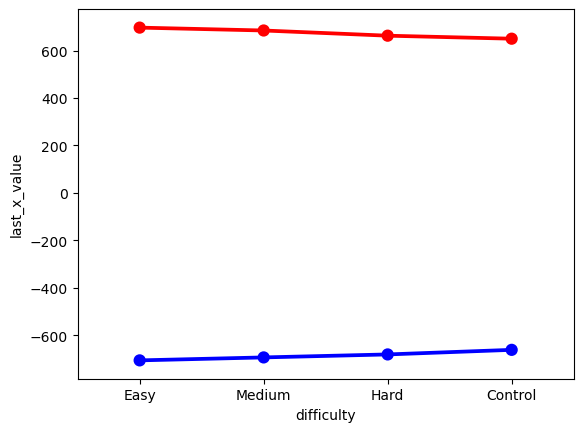

In [ ]:
# Extract the last value from each list in 'x_values'
df['last_x_value'] = df['x_values'].apply(lambda x: x[-1] if len(x) > 0 else np.nan)

df_b = df[df['choice'] == 'Blue']
from scipy import stats
import pingouin as pg

# Create separate dataframes for each difficulty condition
df_easy = df_b[df_b['difficulty'] == 'Easy']
df_medium = df_b[df_b['difficulty'] == 'Medium']
df_hard = df_b[df_b['difficulty'] == 'Hard']
df_control = df_b[df_b['difficulty'] == 'Control']

# Perform one-way ANOVA test for 'Blue'
df_blue = df[(df['choice'] == 'Blue') & df['last_x_value'].notna()]
aov_blue = pg.rm_anova(data=df_blue, dv='last_x_value', within='difficulty', subject='pt_num', detailed=True)
print("One-way ANOVA results for Blue:")
print(aov_blue)
sns.pointplot(data = df_blue, x= 'difficulty', y ='last_x_value', order = ['Easy', 'Medium', 'Hard', 'Control'],color ='blue')

# Perform one-way ANOVA test for 'Red'
df_red = df[(df['choice'] == 'Red') & df['last_x_value'].notna()]
aov_red = pg.rm_anova(data=df_red, dv='last_x_value', within='difficulty', subject='pt_num', detailed=True)
print("One-way ANOVA results for Red:")
print(aov_red)
conditions = ['Easy', 'Medium', 'Hard', 'Control']
sns.pointplot(data = df_red, x= 'difficulty', y ='last_x_value', order = ['Easy', 'Medium', 'Hard', 'Control'],color ='red')



ValueError: setting an array element with a sequence.

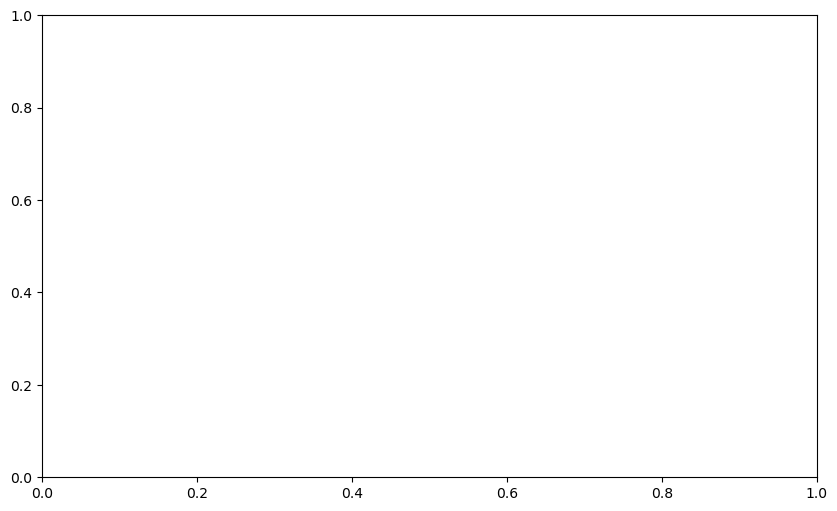

In [ ]:
import matplotlib.pyplot as plt

# Extract x-coordinates for each condition
x_values_hard = df[df['difficulty'] == 'Hard']['x_values'].values
x_values_control = df[df['difficulty'] == 'Control']['x_values'].values
x_values_easy = df[df['difficulty'] == 'Easy']['x_values'].values
x_values_medium = df[df['difficulty'] == 'Medium']['x_values'].values


# Plot the differences
plt.figure(figsize=(10, 6))
plt.plot(x_values_control, label='Control - Hard')
plt.plot(diff_easy_hard, label='Easy - Hard')
plt.plot(diff_medium_hard, label='Medium - Hard')
plt.xlabel('Time')
plt.ylabel('Difference in X-coordinate')
plt.title('Differences between Conditions of X-coordinates')
plt.legend()
plt.show()

In [ ]:
# we are doing this again because we did not take the previous evidence into account initially, then we center the previous evidence around 0 rather than 0.5
data_files = glob.glob(r'../Squircle experiment/data/*.json')
# Load the dataset
df_raw = pd.DataFrame()
for i in range(len(data_files)):
    temp_df = pd.read_json(data_files[i])
    temp_df['previous_diff'] = temp_df['difficulty'].shift(fill_value=None)
    temp_df['previous_trueval'] = temp_df['true_value'].shift(fill_value=None)
    df_raw = pd.concat([df_raw, temp_df])
df_raw = df_raw.drop(df_raw.columns[df_raw.columns.str.contains('Unnamed', case=False)], axis=1)
df_raw = df_raw[(df_raw['block_number'] != 'Training')]

#Adding C values to the dataframe
def assign_muval(row):
    if row['previous_diff'] == 'Control':
        return 0.50
    elif row['previous_diff'] == 'Easy' and row['previous_trueval'] == 'Blue':
        return 0.455
    elif row['previous_diff'] == 'Easy' and row['previous_trueval'] == 'Red':
        return 0.545
    elif row['previous_diff'] == 'Medium' and row['previous_trueval'] == 'Blue':
        return 0.47
    elif row['previous_diff'] == 'Medium' and row['previous_trueval'] == 'Red':
        return 0.53
    elif row['previous_diff'] == 'Hard' and row['previous_trueval'] == 'Blue':
        return 0.48
    elif row['previous_diff'] == 'Hard' and row['previous_trueval'] == 'Red':
        return 0.52
    else:
        return 'NAN'

df_raw['prev_evidence'] = df_raw.apply(assign_muval, axis=1)
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Rescale the value assignments
df_raw['prev_evidence'] = scaler.fit_transform(df_raw['prev_evidence'].values.reshape(-1, 1))

# Check if 'previous_evidence_rescaled' column exists in df_raw
df = df.merge(df_raw[['trial_nbr', 'pt_num', 'prev_evidence']], on=['trial_nbr', 'pt_num'], how='left')
df = df.drop_duplicates(subset=['trial_nbr', 'pt_num'], keep='first')


In [ ]:
#Adding C values to the dataframe
def assign_muval(row):
    if row['difficulty'] == 'Control':
        return 0.50
    elif row['difficulty'] == 'Easy' and row['true_value'] == 'Blue':
        return 0.455
    elif row['difficulty'] == 'Easy' and row['true_value'] == 'Red':
        return 0.545
    elif row['difficulty'] == 'Medium' and row['true_value'] == 'Blue':
        return 0.47
    elif row['difficulty'] == 'Medium' and row['true_value'] == 'Red':
        return 0.53
    elif row['difficulty'] == 'Hard' and row['true_value'] == 'Blue':
        return 0.48
    elif row['difficulty'] == 'Hard' and row['true_value'] == 'Red':
        return 0.52

df['muval'] = df.apply(assign_muval, axis=1)
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Rescale the value assignments
df['evidence'] = scaler.fit_transform(df['muval'].values.reshape(-1, 1))



In [ ]:
df.to_json(r"C:\Users\veoni\Documents\GitHub\MTE_DLAB\Analysis\DF_regress.json")

## Exporting another dataframe for R mixed models with csv
## only with necessary columns
df_r = df.loc[:, ['pt_num', 'trial_nbr', 'block_number', 'acc', 'choice', 'true_value', 'difficulty', 'rt', 'previous_response', 'evidence', 'prev_evidence']]

df_r.to_csv(r"C:\Users\veoni\Documents\GitHub\MTE_DLAB\Analysis\DF_reg_mx.csv")

### Conclusion.
1. After this we export two version of the dataset, one for mouse trajectory specific analyses and other is for the mixed models to see the sequential effects in a conventional manner.